Imports

In [1]:
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from matplotlib import style
from sklearn.metrics import classification_report, confusion_matrix, brier_score_loss, roc_curve, precision_recall_curve, silhouette_score, calinski_harabasz_score, davies_bouldin_score, recall_score, make_scorer, mean_squared_error
from sklearn.calibration import calibration_curve
from sklearn.model_selection import RandomizedSearchCV

Data Loading & Preprocessing

In [2]:
pulsar_dataset = '/home/d.dasarathan/ds5500/projects/datasets/HTRU2/HTRU_2.csv'
pulsar_data = np.loadtxt(pulsar_dataset, delimiter = ',', skiprows=0) 
X, y = pulsar_data[:,:-1], pulsar_data[:,-1]

In [3]:
def upsampling(X_train, y_train):
    X_minority = np.array([X_train[i] for i in range(len(X_train)) if y_train[i] == 1])
    kappa = (1.0 * len(X_minority)) / len(X_train)
    print('total training size: ', len(X_train))
    print('positive class training size: ', len(X_minority))
    repeat = int(1.0 / kappa) - 1
    upsampling = resample(X_minority, n_samples=repeat * len(X_minority))
    y_minority = np.ones(repeat * len(X_minority))
    X_train = np.concatenate((X_train, upsampling))
    print('updated positive class training size: ', len(upsampling))
    y_train = np.concatenate((y_train, y_minority))

def data_prep(X, y, normalize=False, upsample=False, train_val_test=False, train_test=False, k_fold=False, k=None):
  if normalize:
    scaler = StandardScaler().fit(X, y)
    X = scaler.transform(X)
  if train_val_test:
    X, X_test, y, y_test = train_test_split(X, y, test_size=0.2)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    if upsample:
      upsampling(X_train, y_train)
    return X_train, X_val, X_test, y_train, y_val, y_test
  if train_test:
    X, X_test, y, y_test = train_test_split(X, y, test_size=0.2)
    if k_fold:
      data_sets = []
      kf = KFold(n_splits=k, shuffle=True)
      for train_index, val_index in kf.split(X, y):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        if upsample: 
          upsampling(X_train, y_train)
        data_sets.append((X_train, X_val, y_train, y_val))
      if upsample:
        upsampling(X, y)
      return data_sets, X, X_test, y, y_test
    else:
      if upsample: 
        upsampling(X, y)
      return X, X_test, y, y_test
  if k_fold:
    data_sets = []
    kf = KFold(n_splits=k, shuffle=True)
    for train_index, test_index in kf.split(X, y):
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]
      if upsample: 
        upsampling(X_train, y_train)
      data_sets.append((X_train, X_test, y_train, y_test))
    return data_sets, X, y
  return X, y

Display & Plot Evaluation Metrics (Classification)

In [4]:
def eval_clf(clf_pred, clf_pred_prob, y_val, clf_score, alternative_treshold=None, plot=False):
  print("score: ", clf_score)
  print(classification_report(y_val, clf_pred))
  print("confusion matrix:")
  print(confusion_matrix(y_val, clf_pred))
  print("brier score loss: ", brier_score_loss(y_val, clf_pred_prob[:,1]))

  if plot:
    clf_fpr, clf_tpr, clf_thresholds = roc_curve(y_val, clf_pred_prob[:,1])
    plt.plot(clf_fpr, clf_tpr, marker='.')
    plt.title('ROC Curve')
    plt.xlabel('1 - Specifity (FPR)')
    plt.ylabel('Sensitivity (TPR)')
    plt.show()
    plt.plot(clf_thresholds, clf_tpr, marker='.', label='Sensitivity (TPR)')
    plt.plot(clf_thresholds, clf_fpr, marker='.', label='1 - Specifity (FPR)')
    plt.plot(clf_thresholds, clf_tpr - clf_fpr, marker='.', label='Difference (TPR - FPR)')
    plt.xlim([0.0, 1.0])
    plt.title('Sensitivity / 1 - Specifity / Difference vs. Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Sensitivity / 1 - Specifity / Difference')
    plt.legend()
    plt.show()

    clf_precision, clf_recall, clf_thresholds = precision_recall_curve(y_val, clf_pred_prob[:,1])
    plt.plot(clf_recall, clf_precision, marker='.')
    plt.title('PRC Curve')
    plt.xlabel('Recall (TPR)')
    plt.ylabel('Precision (PPV)')
    plt.show()

    clf_frac_pos, clf_prob_pos = calibration_curve(y_val, clf_pred_prob[:,1], n_bins=10, strategy='uniform')
    plt.plot(clf_prob_pos, clf_frac_pos, marker='.')
    plt.title('Calibration')
    plt.xlabel('Probability')
    plt.ylabel('Fraction of Positives')
    plt.show()

  if alternative_treshold:
    print("Threshold = ", alternative_treshold, ":")
    clf_new_pred = [1 * (clf_pred_sample_prob[1] > alternative_treshold) for clf_pred_sample_prob in clf_pred_prob]
    print(classification_report(y_val, clf_new_pred))
    print("confusion matrix:")
    print(confusion_matrix(y_val, clf_new_pred))

#### Self-Organizing Map

In [5]:
import tensorflow as tf
class SOM(object):
  def __init__(self, map_dim_x, map_dim_y, input_dim, learning_rate_init, radius_init, num_iter=100):

    # Initialize properties
    self.map_dim_x = map_dim_x
    self.map_dim_y = map_dim_y
    self.input_dim = input_dim
    self.learning_rate_init = tf.cast(learning_rate_init, tf.float64)
    self.radius_init = tf.cast(radius_init, tf.float64)
    self.num_iter = num_iter

    # Initialize variables and constants:
    self.weights = tf.Variable(tf.cast(tf.random.normal([map_dim_x, map_dim_y, input_dim]), dtype=tf.float64)) # weights[i, j, k] is weight of output node [i,j] connected to input node k
    self.coords = tf.constant(np.array([np.array([np.array([i, j]) for j in range(self.map_dim_y)]) for i in range(self.map_dim_x)]))

  @tf.function
  def train_step(self, input_vect, iter_no):
    input_tensor = tf.stack([tf.stack([input_vect for j in range(self.map_dim_y)]) for i in range(self.map_dim_x)])

    # Calculate BMU
    distances_weights_to_input = self.distance_3d(self.weights, input_tensor)
    bmu = self.argmin_2d(distances_weights_to_input) # returns coord of output node [i, j]

    # Update Learning Rate and Radius for Output Nodes
    decay = tf.exp(tf.negative(tf.divide(iter_no, self.num_iter)))
    
    learning_rate = tf.cast(tf.multiply(self.learning_rate_init, decay), dtype=tf.float64)
    radius =  tf.cast(tf.multiply(self.radius_init, decay), dtype=tf.float64)

    bmu_tensor = tf.stack([tf.stack([bmu for j in range(self.map_dim_y)]) for i in range(self.map_dim_x)])
    distances_output_nodes_to_bmu = self.distance_3d(self.coords, bmu_tensor)
    neighborhood_influence = tf.exp(tf.negative(tf.pow(tf.divide(distances_output_nodes_to_bmu, tf.multiply(radius, 2.0)), 2.0)))

    # Update Weights
    update_coeff_tensor = tf.tile(tf.reshape(tf.multiply(learning_rate, neighborhood_influence), [self.map_dim_x, self.map_dim_y, 1]), [1, 1, self.input_dim])
    update = tf.multiply(update_coeff_tensor, tf.subtract(input_tensor, self.weights))
    new_weights = tf.add(self.weights, update)
    self.weights.assign(new_weights)
  
  def train(self, train_data):
    for iter_no in range(self.num_iter):
      for input_vect in train_data:
        self.train_step(input_vect, iter_no)
    self.centroids = self.weights

  def predict(self, train_data):
    mappings_input_to_output = []
    for input_vect in train_data:
      input_tensor = tf.stack([tf.stack([input_vect for j in range(self.map_dim_y)]) for i in range(self.map_dim_x)])
      output_node = np.array(self.argmin_2d(self.distance_3d(self.weights, input_tensor)))
      mappings_input_to_output.append(output_node)
    return mappings_input_to_output

  def get_centroid(self, i, j):
    return list(self.centroids[i][j])
  
  def distance_3d(self, tensor1, tensor2):
    return tf.sqrt(tf.reduce_sum(tf.pow(tf.subtract(tf.cast(tensor1, dtype=tf.float64), tf.cast(tensor2, dtype=tf.float64)), 2), 2))
    
  def argmin_2d(self, tensor):
    flat_tensor = tf.reshape(tensor, [self.map_dim_x * self.map_dim_y])
    argmin_flat_tensor = tf.argmin(flat_tensor, 0)
    argmin_x = argmin_flat_tensor // self.map_dim_x
    argmin_y = argmin_flat_tensor % self.map_dim_x
    return [argmin_x, argmin_y]

2022-11-07 21:50:57.683185: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-07 21:50:57.947202: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /shared/centos7/anaconda3/2021.05/lib:/shared/centos7/nodejs/14.15.4/lib
2022-11-07 21:50:57.947246: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-07 21:50:57.992901: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has a

Self-Organizing Map

In [6]:
def som(unsup_data, output_dim_x, output_dim_y, num_iter):
  som = SOM(output_dim_x, output_dim_y, len(unsup_data[0]), 0.1, 0.1, num_iter)
  som.train(unsup_data)
  som_pred = som.predict(unsup_data)
  som_output_nodes = [[[] for _ in range(output_dim_y)] for _ in range(output_dim_x)]
  for i in range(len(som_pred)):
    x, y = som_pred[i]
    som_output_nodes[x][y].append(unsup_data[i])
  som_centroids = [[0 for _ in range(output_dim_y)] for _ in range(output_dim_x)]
  for i in range(output_dim_x):
    for j in range(output_dim_y):
      som_centroids[i][j] = []
      for component in som.get_centroid(i,j):
        som_centroids[i][j].append(float(component))
  return som_pred, som_output_nodes, som_centroids

Principal Component Analysis

In [7]:
from sklearn.decomposition import PCA
def pca(unsup_data, n_components):
  dcmp = PCA(n_components)
  pca_transformed_data = dcmp.fit_transform(unsup_data)
  return dcmp.components_, pca_transformed_data, dcmp.explained_variance_, dcmp

Display Evaluation Metrics (Clustering)

In [8]:
def flatten_label(label, dim):
  x, y = label
  return x * dim + y

def eval_clr(unsup_data, clr_labels, flatten=False, flatten_dim=None):
  if flatten:
    clr_labels = [flatten_label(label, flatten_dim) for label in clr_labels]
  print("Silhouette Coefficient: ", silhouette_score(unsup_data, clr_labels))


Main

SOM Results:


2022-11-07 21:51:02.402497: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /shared/centos7/anaconda3/2021.05/lib:/shared/centos7/nodejs/14.15.4/lib
2022-11-07 21:51:02.402594: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-07 21:51:02.402640: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (c0179): /proc/driver/nvidia/version does not exist
2022-11-07 21:51:02.403476: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[[[50.29278346083289, 39.7629349818391, 3.641166329322785, 19.377902760729494, 113.5564698131563, 82.14822849694, 0.05249681290362578, -0.9490269424493482], [-0.561566435660402, 0.3912732949872674, 0.9916486830409704, -0.5361268456590536, -0.10616377420501467, 1.162761180169305, -0.7303485793328904, 2.000492351019845], [2.115267515182495, -0.3070294260978699, -0.5363616943359375, -1.7327274084091187, 0.46592044830322266, -1.330027461051941, 0.6242750883102417, 0.07403792440891266], [-0.3215344681254953, 0.3933025465100142, -0.004872925964460051, 0.3683916235414911, -0.14762367655776798, 0.8412013994906996, -1.0239905027631717, 0.5490544177338538], [69.48559898789411, 39.41414461761598, 2.388300031430723, 10.816584226341904, 28.744068374894262, 57.6529676657327, 2.8902856681550624, 11.714400546503768]], [[-0.9558609347089365, -0.5300884165708625, 0.23450040480219386, 1.2916008833461965, -0.5254791407570595, 0.28454932718184445, -0.8911389626175411, 0.46642126824981267], [-0.498299151659

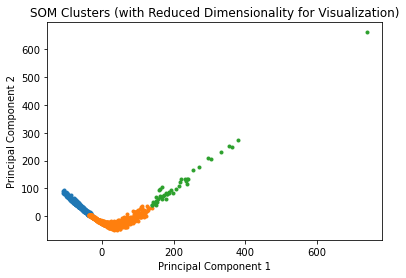

Silhouette Coefficient:  0.4418700300386931


In [9]:
X, y = pulsar_data[:,:-1], pulsar_data[:,-1]
X, y = data_prep(X, y)
unsup_data = np.array([X[i] for i in range(len(X)) if y[i] == 1])

pca_principal_components, pca_transformed_data, pca_explained_variance, pca_trained = pca(unsup_data, 2)

print("SOM Results:")
som_pred, som_clusters, som_centroids = som(unsup_data, 5, 5, 100)
print(som_centroids)
print(np.shape(np.array(som_centroids)))
for i in range(len(som_clusters)):
  for j in range(len(som_clusters[0])):
    if len(som_clusters[i][j]) != 0:
      print("CLUSTER")
      print("Centroid:")
      print(som_centroids[i][j])
      print("Count:")
      print(len(som_clusters[i][j]))
      pca_transformed_cluster = pca_trained.transform(som_clusters[i][j])
      plt.scatter(pca_transformed_cluster[:,0], pca_transformed_cluster[:,1], marker='.')
plt.title('SOM Clusters (with Reduced Dimensionality for Visualization)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()
eval_clr(unsup_data, som_pred, flatten=True, flatten_dim=5)